In [10]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torchvision
import os
from torchvision.models.densenet import densenet121, DenseNet121_Weights
import torch.nn as nn
import numpy as np
import torch
# from models.checker_model import CheckerModel
from sklearn import metrics
import os
from tqdm.auto import tqdm
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import yaml
import shutil 
from joblib import Parallel, delayed
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
from skimage import io
from torchvision.datasets.folder import default_loader

#Load config and setup environment 
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config
path_to_config = 'config.yaml'
# paths variable holds all paths from the config
paths = load_config(path_to_config)
# chooce concept 
primary_concept = "person"
#Choose GPU 
gpu = "7"
device = f"cuda:{gpu}" if torch.cuda.is_available() else "cpu"
coco_concepts = paths["coco_concepts"]
                     

In [11]:
def get_auroc(loader,model):
    y_true, y_score = [], []
    model.eval()
    with torch.no_grad():
        for X, y, id in loader:
            X = X.to(device).half()
            y = y.to(device).half()
            output = model(X)
            y_true.append(y)
            y_score.append(output.data)
    y_true = torch.cat(y_true)
    y_score = torch.cat(y_score)
    auroc = metrics.roc_auc_score(y_true.cpu(), y_score.cpu(), average=None)
    return auroc 
    
class TargetModel(nn.Module):
    def __init__(self,device, primary_or_mixed):
        super().__init__()
        self.primary_or_mixed = primary_or_mixed
        all_model = densenet121(weights=DenseNet121_Weights.DEFAULT)
        all_model.classifier = torch.nn.Linear(all_model.classifier.in_features, 80)
        
        # Freeze all layers
        for param in all_model.parameters():
            param.requires_grad = False

        self.all_model = all_model
        self.lin = nn.Linear(15,1,device=device)
        
    def forward(self, x):
        x = self.all_model(x)
        idxs_to_use = [0, 39, 41, 45, 56, 57, 59, 60, 62, 63, 65, 67, 69, 71, 73]
        concept_predictions = x[:,idxs_to_use]
        x = self.lin(concept_predictions)
        x = torch.squeeze(x)
        return x 
        
class ConceptClassifier(nn.Module):
    def __init__(self,device,model_path):
        super(ConceptClassifier, self).__init__()
        model_state_dict = torch.load(model_path, map_location=device)['state_dict']
        all_model = densenet121(weights=DenseNet121_Weights.DEFAULT)
        all_model.classifier = torch.nn.Linear(all_model.classifier.in_features, 80)
        #model put on device by loading state dict with map_location = device above 
        all_model.load_state_dict(model_state_dict)
        self.all_model = all_model
    def forward(self, x):
        x = self.all_model(x)
        idxs_to_use = [0, 39, 41, 45, 56, 57, 59, 60, 62, 63, 65, 67, 69, 71, 73]
        x = x[:,idxs_to_use]
        return x

class Dataset(Dataset):
    def __init__(self, df, outcome, n_outcome):
        self.df = df
        self.outcome = outcome
        self.n_outcome = n_outcome
        trans = [transforms.ToTensor(),
                transforms.Resize(256),
                transforms.CenterCrop(256),
                transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
        self.trans = transforms.Compose(trans)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = default_loader(self.df.loc[idx, "file_name"])
        img = self.trans(img)
        if self.n_outcome > 1:
            label = self.df.loc[idx, self.outcome]
        else:
            label = row[self.outcome]
        return img, torch.tensor(label), row.image_id

In [12]:
# Load concept classifier 
concept_model_path = "../" + paths['primary_concept_model_path']
concept_classifier = ConceptClassifier(device,concept_model_path)
concept_classifier = concept_classifier.half().to(device)
concept_classifier.eval()

# Load in target model
target_model = TargetModel(device, "primary")

# Load Saved Weights
model_path_df = pd.read_csv('../best_primary_models.csv', index_col = 'feature')
model_path = "../" + model_path_df.loc[primary_concept,'model_path']
checkpoint = torch.load(model_path, map_location=device)
target_model.load_state_dict(checkpoint['state_dict'])
target_model = target_model.half().to(device)
target_model.eval()
print(f"Done Loading Models")

Done Loading Models


In [13]:
# read in dataset 


        
df = pd.read_csv("metadata/orig.csv")
df = df[["image_id", "file_name", "home or hotel", *coco_concepts]]
# eval on real images 
realDataset = Dataset(df, "home or hotel", 1)
realLoader = DataLoader(realDataset, batch_size=32, shuffle=False, num_workers=4)
real_auroc = get_auroc(realLoader, target_model)

# check concepts 
realDataset = Dataset(df, coco_concepts, len(coco_concepts))
realLoader = DataLoader(realDataset, batch_size=32, shuffle=False, num_workers=1)
concept_real_auroc = get_auroc(realLoader, concept_classifier)
real_auroc, concept_real_auroc

(0.9679133607705037,
 array([0.94776507, 0.85804426, 0.86264872, 0.91123446, 0.86308396,
        0.91461071, 0.93839272, 0.91709591, 0.93371677, 0.96753389,
        0.85929895, 0.8838668 , 0.97762908, 0.97410122, 0.87333966]))

In [14]:
# read in dataset 
df = pd.read_csv("metadata/orig.csv")
df = df[["image_id", "file_name", "home or hotel", *coco_concepts]]
# eval on generated images 
df["file_name"] = df["image_id"].apply(lambda x: f"images/perm_0/perm_gen_no_perm/{x}.png")
genDataset = Dataset(df, "home or hotel", 1)
genLoader = DataLoader(genDataset, batch_size=32, shuffle=False, num_workers=4)
# eval on generated images 
gen_auroc = get_auroc(genLoader, target_model) 

# check concepts 
genDataset = Dataset(df, coco_concepts, len(coco_concepts))
genLoader = DataLoader(genDataset, batch_size=32, shuffle=False, num_workers=1)
concept_gen_auroc = get_auroc(genLoader, concept_classifier)
gen_auroc, concept_gen_auroc

(0.9059304595018881,
 array([0.91538143, 0.82772129, 0.83800918, 0.87779751, 0.87089646,
        0.9166545 , 0.91917805, 0.88056542, 0.96536017, 0.95672847,
        0.86028026, 0.87009962, 0.92267552, 0.92376963, 0.88006009]))

In [15]:
print("Checking Effective Generation")
baseline_aurocs = pd.DataFrame([[real_auroc, *concept_real_auroc], [gen_auroc, *concept_gen_auroc]], columns = ["home or hotel", *coco_concepts], index = ["Real Image", "Generated Images"]).round(2)
baseline_aurocs

Checking Effective Generation


,home or hotel,person,bottle,cup,bowl,chair,couch,bed,dining table,tv,laptop,remote,cell phone,oven,sink,book
Real Image,0.97,0.95,0.86,0.86,0.91,0.86,0.91,0.94,0.92,0.93,0.97,0.86,0.88,0.98,0.97,0.87
Generated Images,0.91,0.92,0.83,0.84,0.88,0.87,0.92,0.92,0.88,0.97,0.96,0.86,0.87,0.92,0.92,0.88


In [17]:
%%time
print("hi")

hi
CPU times: user 0 ns, sys: 60 µs, total: 60 µs
Wall time: 73 µs


In [20]:
%%time

# evaluate on permutations 
concept_to_perm = {}
changes = []
for concept in coco_concepts:
    concept_perm_aurocs = []
    for perm_num in tqdm(range(25)): 
        # eval on generated images 
        df["file_name"] =  df["image_id"].apply(lambda x: f"images/perm_{perm_num}/perm_gen_{concept}/{x}.png")
        genDataset = Dataset(df, "home or hotel", 1)
        genLoader = DataLoader(genDataset, batch_size=200, shuffle=False, num_workers=4)
        # eval on generated images 
        gen_auroc = get_auroc(genLoader, target_model) 
        
        # check concepts 
        genDataset = Dataset(df, coco_concepts, len(coco_concepts))
        genLoader = DataLoader(genDataset, batch_size=50, shuffle=False, num_workers=5)
        concept_gen_auroc = get_auroc(genLoader, concept_classifier)
        concept_perm_aurocs.append([gen_auroc, *concept_gen_auroc])
    concept_to_perm[concept] = concept_perm_aurocs
    changes.append(np.abs(np.array(baseline_aurocs.iloc[1].values - np.array(concept_to_perm[concept]))))

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

CPU times: user 5min 46s, sys: 4min 20s, total: 10min 6s
Wall time: 39min 59s


In [21]:
# save intermediate results so you don't have to rerun them! 
import pickle
pickle.dump(concept_to_perm, open("concept_to_perm.p", "wb"))
pickle.dump(changes, open("changes.p", "wb"))

Appendix Figure 2: Independent permutation


Text(0.5, 0, 'Concept Classifier Targets')

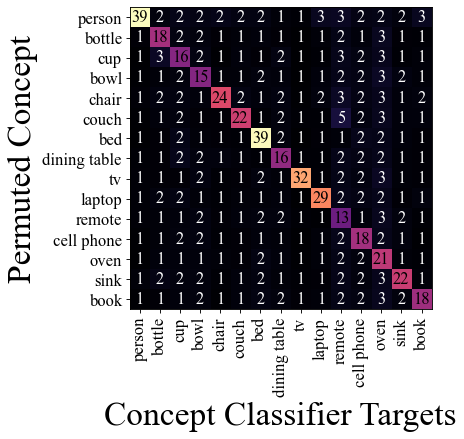

In [22]:
print("Appendix Figure 2: Independent permutation")
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(5, 5), dpi=80)

stats = np.array(changes).mean(axis = 1)[:,1:]

plt.imshow(stats, cmap='magma')

# Show all ticks and label them with the respective list entries
plt.xticks(np.arange(len(coco_concepts)), labels=coco_concepts, fontsize = 15, rotation = 90)
plt.yticks(np.arange(len(coco_concepts)), labels=coco_concepts, fontsize = 15)
# Loop over data dimensions and create text annotations.
for i in range(len(coco_concepts)):
    for j in range(len(coco_concepts)):
        if i != j:
            text = plt.text(j, i, "{:.0f}".format(stats[i, j]*100),
                       ha="center", va="center", color="w", fontsize = 15)
        else:
            text = plt.text(j, i, "{:.0f}".format(stats[i, j]*100),
                       ha="center", va="center", color="black", fontsize = 15)
# plt.title("Diffusion-Generated Permutation", fontsize = 40)
plt.ylabel("Permuted Concept", fontsize = 30)
plt.xlabel("Concept Classifier Targets", fontsize = 30)


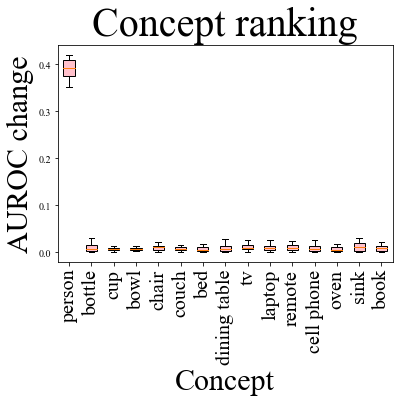

In [48]:
# Plot concept ranking 
_ = plt.boxplot(np.array(changes)[:,:,1].T, patch_artist=True, boxprops=dict(facecolor="pink"), showfliers=False,  labels = coco_concepts)
plt.xticks(rotation = 90, fontsize = 20)
plt.ylabel("AUROC change", fontsize = 30)
plt.xlabel("Concept", fontsize = 30) 
plt.title("Concept ranking", fontsize = 40)
plt.show()